In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(1.))

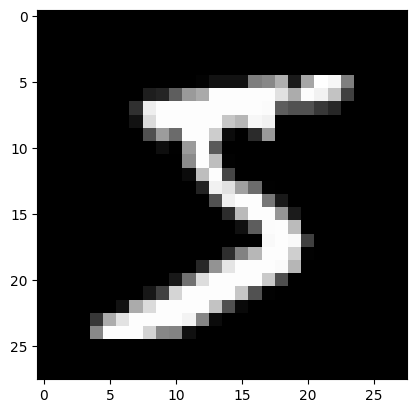

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

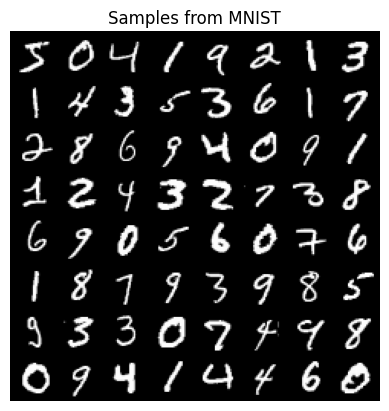

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST');

In [6]:
class Encoder(nn.Module):
    def __init__(self, img_channels, hidden_dim, z_dim):
        super().__init__()

        self.z_dim = z_dim
        
        self.net = nn.Sequential( # 28x28
            self.__basic_block(img_channels, hidden_dim, kernel_size=4, stride=2), # 13x13
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2), # 5x5
            self.__basic_block(hidden_dim*2, hidden_dim*4, kernel_size=4, stride=2), # 1x1
            nn.Flatten(),
            nn.Linear(hidden_dim*4, z_dim)
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.net(x)

Encoder(1, 20, 2)(torch.randn(64, 1, 28, 28)).shape

torch.Size([64, 2])

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, img_channels):
        super().__init__()

        self.net = nn.Sequential( # 1x1
            self.__basic_block(in_channels=z_dim, out_channels=hidden_dim*4, kernel_size=3, stride=1), # 3x3
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1), # 6x6
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2), # 13x13
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2), # 28x28
            nn.Sigmoid(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)
    
Decoder(2, 20, 1)(torch.randn(64, 2, 1, 1)).shape

torch.Size([64, 1, 28, 28])

In [8]:
class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.net = nn.Sequential( # Bx2
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x).flatten()

Discriminator(2)(torch.randn(64, 2)).shape

torch.Size([64])

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
reconstruction_loss = nn.BCELoss(reduction='sum')
discriminator_loss = nn.BCELoss()

train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

z_dim = 2
encoder = Encoder(img_channels=1, hidden_dim=20, z_dim=z_dim).to(device)
decoder = Decoder(img_channels=1, hidden_dim=20, z_dim=z_dim).to(device)
discriminator = Discriminator(z_dim=z_dim).to(device)

from itertools import chain
opt_encoder_decoder = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001)
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)

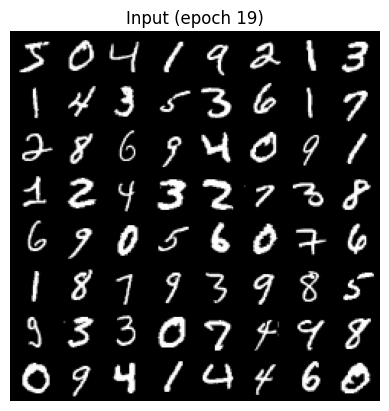

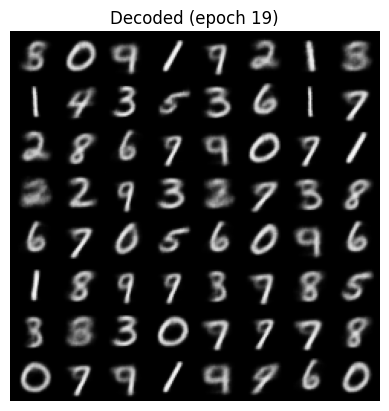

In [12]:
for epoch in range(20):
    for images, _ in train_loader:
        images = images.to(device)

        encoded_images = encoder(images)
        decoded_images = decoder(encoded_images[:, :, None, None])
        
        discriminator_pred = discriminator(encoded_images)

        loss_encoder_decoder = reconstruction_loss(decoded_images, images) + 0.001*discriminator_loss(discriminator_pred, torch.ones_like(discriminator_pred))

        opt_encoder_decoder.zero_grad()
        loss_encoder_decoder.backward()
        opt_encoder_decoder.step()

        
        prior_noise = torch.randn_like(encoded_images)
        discriminator_pred_real = discriminator(prior_noise)
        discriminator_pred_fake = discriminator(encoded_images.detach())

        fake_loss_disc = discriminator_loss(discriminator_pred_fake, torch.zeros_like(discriminator_pred_fake))
        real_loss_disc = discriminator_loss(discriminator_pred_real, torch.ones_like(discriminator_pred_real))
        loss_discriminator = fake_loss_disc + real_loss_disc

        opt_discriminator.zero_grad()
        loss_discriminator.backward()
        opt_discriminator.step()

    clear_output()
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    show_images(decoder(encoder(torch.stack([dataset[i][0] for i in range(64)]).to(device))[:, :, None, None]).cpu(), title=f'Decoded (epoch {epoch})');

## Visualization

In [13]:
encoder = encoder.cpu()
decoder = decoder.cpu()
discriminator = discriminator.cpu()

encoder.eval()
decoder.eval()
discriminator.eval();

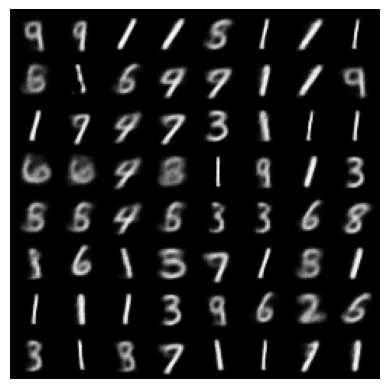

In [20]:
from torch.distributions.normal import Normal

noise = Normal(torch.zeros((z_dim, ), dtype=torch.float), torch.ones((z_dim, ), dtype=torch.float)).sample((64, ))
show_images(decoder(noise[:, :, None, None]), nrow=8);

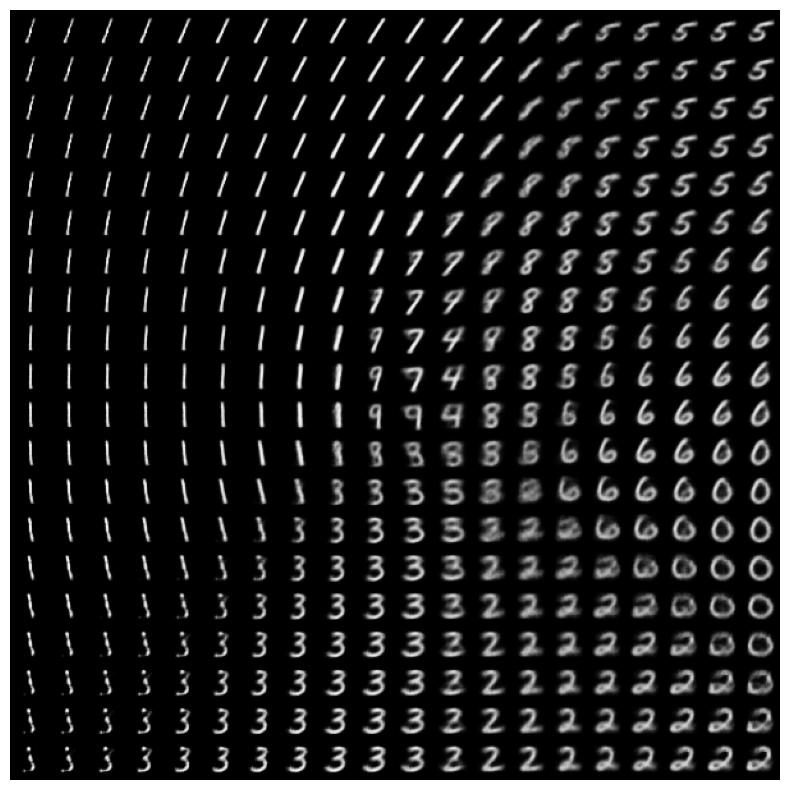

In [22]:
x_range = torch.linspace(-3, 3, 20)
y_range = torch.linspace(-3, 3, 20)
grid = torch.dstack(torch.meshgrid((x_range, y_range)))

plt.figure(figsize=(10, 10))
show_images(decoder(grid.reshape(-1, 2, 1, 1)), nrow=20);

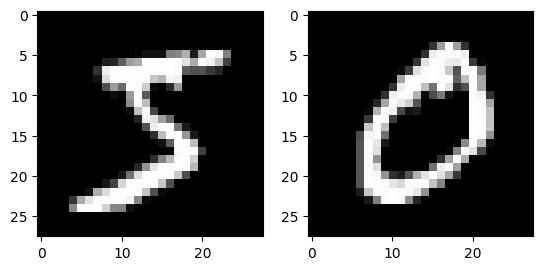

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dataset[1][0].permute(1, 2, 0), cmap='gray');

torch.Size([15, 2])


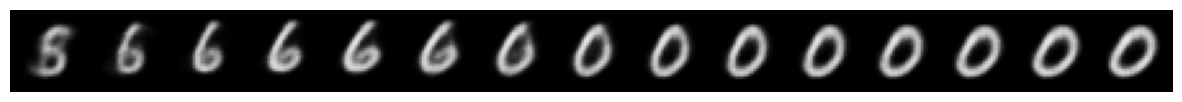

In [28]:
e1 = encoder(dataset[1][0].unsqueeze(0))
e2 = encoder(dataset[0][0].unsqueeze(0))
t = torch.linspace(0, 1, 15)[:, None]
interpolated_means = t@e1 + (1-t)@e2
print(interpolated_means.shape)

plt.figure(figsize=(15, 5))
show_images(decoder(interpolated_means[:, :, None, None]), nrow=15);

In [70]:
# x_range = torch.linspace(-3, 3, 20)
# y_range = torch.linspace(-3, 3, 20)
# grid = torch.dstack(torch.meshgrid((x_range, y_range)))

# plt.figure(figsize=(10, 10))
# show_images(decoder(grid.reshape(-1, 2, 1, 1)), nrow=20);

In [71]:
# images, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=1024)))
# means = encoder(images)[0].detach()

# plt.figure(figsize=(8, 7))
# scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, s=15)
# plt.legend(*scatter.legend_elements());

In [ ]:
mean_images = []
std_images = []
encoded_labels = []
for images, labels in train_loader:
    m, s = model.encoder(images)
    mean_images.append(m.detach())
    std_images.append(s.detach())
    encoded_labels.append(labels)
    
mean_images = torch.cat(mean_images, dim=0)
std_images = torch.cat(std_images, dim=0)
encoded_labels = torch.cat(encoded_labels)

mean_images.shape, std_images.shape, encoded_labels.shape

(torch.Size([60000, 2]), torch.Size([60000, 2]), torch.Size([60000]))

In [ ]:
classes_mean, classes_std = torch.zeros((10, 2)), torch.zeros((10, 2))
for idx in range(10):
    classes_mean[idx] = torch.mean(mean_images[encoded_labels == idx], axis=0)
    classes_std[idx] = torch.mean(std_images[encoded_labels == idx], axis=0)
classes_mean, classes_std

(tensor([[-0.1436,  2.3545],
         [ 2.1190, -0.8741],
         [-0.7365,  0.6879],
         [-0.1906,  0.2948],
         [-0.3361, -0.6174],
         [ 0.3142,  0.3828],
         [-0.0840,  1.2307],
         [ 0.3867, -1.0495],
         [ 0.3433,  0.1944],
         [-0.1534, -0.6973]]),
 tensor([[0.0882, 0.0923],
         [0.1052, 0.0956],
         [0.0894, 0.0509],
         [0.0609, 0.0486],
         [0.0833, 0.0588],
         [0.0722, 0.0576],
         [0.0856, 0.0617],
         [0.0642, 0.0696],
         [0.0684, 0.0518],
         [0.0665, 0.0654]]))

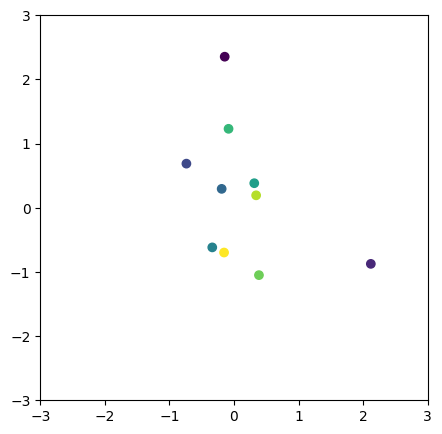

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(classes_mean[:, 0], classes_mean[:, 1], c=range(10));
plt.show()